# Analyzing consumer behavior and investor sentiment within the cannabis industry

## Set up

In [1]:
import requests
from bs4 import BeautifulSoup

from datetime import datetime

import pandas as pd
import numpy as np

import string
import re
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
from textblob import TextBlob

import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trist\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Market analysis

In [2]:
data_path = "C:/Users/trist/OneDrive/Desktop/Trist'n/School/Syracuse University/Q3 2021/IST652/Homework/Homework 1/transactions_csv_AprilJune2021.csv"
transactions_df = pd.read_csv(data_path)
transactions_df.head(5)

,os__id,os__cart_id,os__cart_creation_time,os__product_added_to_cart_time,os__checkout_time,os__user_id,os__product_id,os__store_id,os__special,os__promo_code,...,s__estimated_county,u__id,u__first_name,u__birth_date,u__created_at,u__updated_at,u__gender,u__nationality_general,u__nationality_general_perc,u__nationality_specific_perc
0,95378515,40850333,2021-04-14T15:26:38.552Z,2021-04-14T15:27:31.397Z,2021-04-14T15:27:55.545Z,201,301882,15027953,NaN,NaN,...,San Benito,201,Tara,1978-03-13T00:00:00.000Z,2017-05-06T01:34:16.954Z,2021-05-26T15:25:04.052Z,female,white,0.9,0.97
1,92286351,39583416,2021-04-03T17:12:31.638Z,2021-04-03T17:12:31.649Z,2021-04-03T17:13:25.847Z,201,20447,15027953,1¢ Preroll for Every $30 Spent,NaN,...,San Benito,201,Tara,1978-03-13T00:00:00.000Z,2017-05-06T01:34:16.954Z,2021-05-26T15:25:04.052Z,female,white,0.9,0.97
2,108424703,46130648,2021-05-26T15:24:40.728Z,2021-05-26T15:24:40.739Z,2021-05-26T15:25:01.580Z,201,16385,15027953,NaN,NaN,...,San Benito,201,Tara,1978-03-13T00:00:00.000Z,2017-05-06T01:34:16.954Z,2021-05-26T15:25:04.052Z,female,white,0.9,0.97
3,98836271,42160004,2021-04-23T16:37:51.279Z,2021-04-23T16:37:51.295Z,2021-04-23T16:38:11.296Z,201,16385,15027953,NaN,NaN,...,San Benito,201,Tara,1978-03-13T00:00:00.000Z,2017-05-06T01:34:16.954Z,2021-05-26T15:25:04.052Z,female,white,0.9,0.97
4,95378211,40850333,2021-04-14T15:26:38.552Z,2021-04-14T15:26:38.564Z,2021-04-14T15:27:55.545Z,201,410684,15027953,NaN,NaN,...,San Benito,201,Tara,1978-03-13T00:00:00.000Z,2017-05-06T01:34:16.954Z,2021-05-26T15:25:04.052Z,female,white,0.9,0.97


In [3]:
# Converting the columns to the appropriate types 
transactions_df['os__id'] = transactions_df['os__id'].astype('string')
transactions_df['os__cart_id'] = transactions_df['os__cart_id'].astype('string')
transactions_df['os__store_id'] = transactions_df['os__store_id'].astype('string')
transactions_df['os__user_id'] = transactions_df['os__user_id'].astype('string')
transactions_df['os__product_id'] = transactions_df['os__product_id'].astype('string')
transactions_df['p__id'] = transactions_df['p__id'].astype('string')
transactions_df['u__id'] = transactions_df['u__id'].astype('string')
transactions_df['s__id'] = transactions_df['s__id'].astype('string')
transactions_df['os__checkout_date'] = transactions_df['os__checkout_date'].astype('datetime64[ns]')

In [4]:
# Creating the `granular_product` column
transactions_df['granular_product'] = transactions_df['p__product_name'].astype(str) + ': ' + transactions_df['p__product_category'].astype(str) + ', by ' + transactions_df['p__serial_brand'].astype(str)

In [5]:
# Which county has the highest total sales during the period?
# aggregating by county to find the one with the highest sales
county_total_sales = transactions_df \
    .groupby('s__estimated_county') \
    .agg(
        total_sales = pd.NamedAgg('os__sales', sum)
    ) \
    .sort_values('total_sales', ascending=False)

county_total_sales.head(5)

,total_sales
s__estimated_county,
Santa Clara,1036836.89
San Francisco,593825.27
San Diego,309448.42
Butte,299935.66
Los Angeles,287564.80


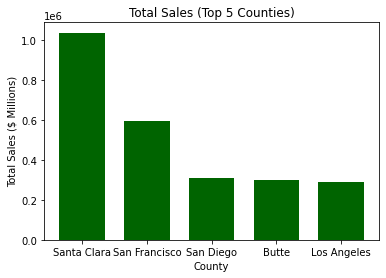

In [6]:
# creating a barplot for the top 5 counties
plt.bar(county_total_sales.index[:5], county_total_sales['total_sales'][:5], color='darkgreen', width=0.7)
plt.xlabel('County')
plt.ylabel('Total Sales ($ Millions)')
plt.title('Total Sales (Top 5 Counties)')
plt.show()

### Top market

In [7]:
# Exploring the county with the highest sales: Santa Clara
# subsetting the data frame to only include transactions from Santa Clara
santa_clara = transactions_df[transactions_df['s__estimated_county'] == 'Santa Clara']

In [8]:
# Per day statistics
santa_clara_per_day_stats = santa_clara \
    .groupby('os__checkout_date') \
    .agg(
        total_sales = pd.NamedAgg('os__sales', 'sum'),
        avg_transaction_value = pd.NamedAgg('os__sales', 'mean'),
        total_units = pd.NamedAgg('os__n_units', 'sum'),
        avg_units_per_transaction = pd.NamedAgg('os__n_units', 'mean')
    ) \
    .sort_values('os__checkout_date', ascending=False)

santa_clara_per_day_stats.head()

,total_sales,avg_transaction_value,total_units,avg_units_per_transaction
os__checkout_date,,,,
2021-05-31,15717.09,36.808173,554,1.297424
2021-05-30,15573.06,37.983073,531,1.295122
2021-05-29,17314.21,36.682648,590,1.250000
2021-05-28,21534.78,35.712736,718,1.190713
2021-05-27,18053.51,37.690000,610,1.273486


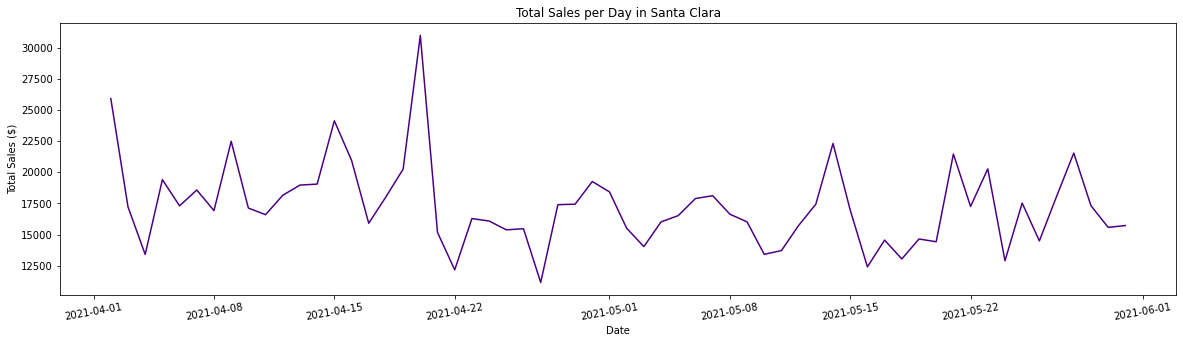

In [9]:
fig = plt.figure(figsize = (20, 5))
plt.plot(santa_clara_per_day_stats.index, santa_clara_per_day_stats['total_sales'], color='indigo')
plt.xticks(rotation = 10)
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.title('Total Sales per Day in Santa Clara')
plt.show()

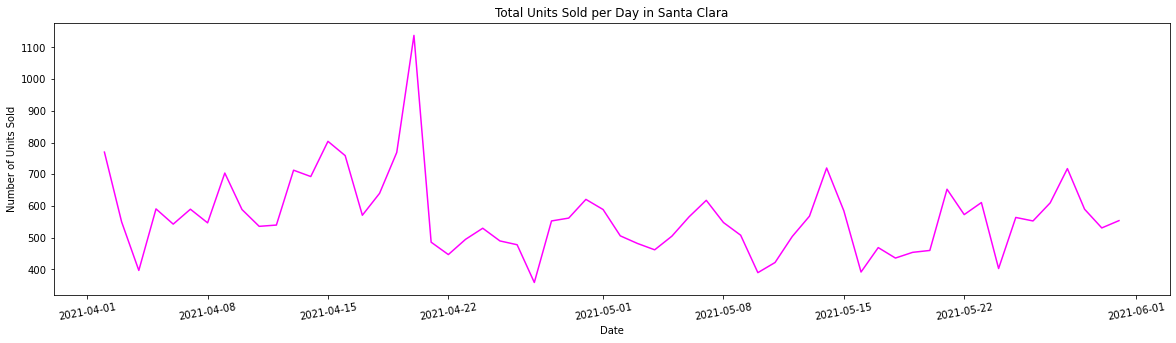

In [10]:
fig = plt.figure(figsize = (20, 5))
plt.plot(santa_clara_per_day_stats.index, santa_clara_per_day_stats['total_units'], color='magenta')
plt.xticks(rotation = 10)
plt.xlabel('Date')
plt.ylabel('Number of Units Sold')
plt.title('Total Units Sold per Day in Santa Clara')
plt.show()

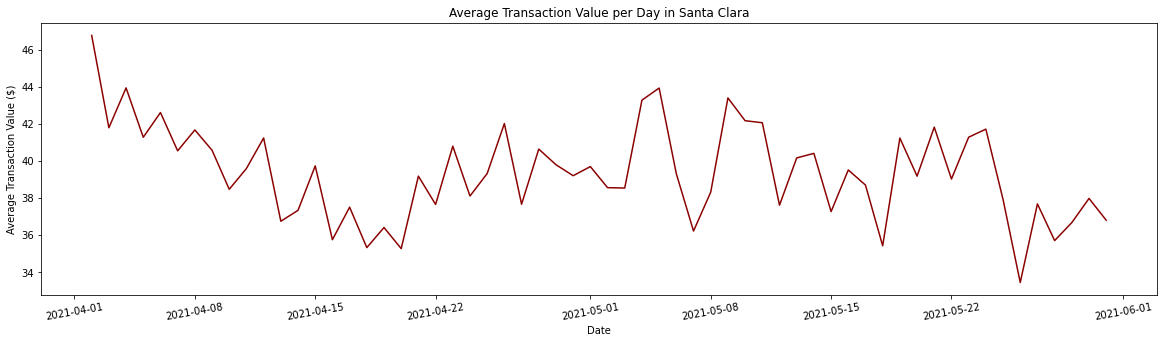

In [11]:
fig = plt.figure(figsize = (20, 5))
plt.plot(santa_clara_per_day_stats.index, santa_clara_per_day_stats['avg_transaction_value'], color='darkred')
plt.xticks(rotation = 10)
plt.xlabel('Date')
plt.ylabel('Average Transaction Value ($)')
plt.title('Average Transaction Value per Day in Santa Clara')
plt.show()

In [12]:
# What are the top 5 brandsin Santa Clara?
# aggregating by brands
sanat_clara_top_brand = santa_clara \
    .groupby('p__serial_brand') \
    .agg(
        total_sales = pd.NamedAgg('os__sales', 'sum'),
        total_units = pd.NamedAgg('os__n_units', 'sum'),
    ) \
    .sort_values('total_sales', ascending=False)

sanat_clara_top_brand.head(5)

,total_sales,total_units
p__serial_brand,,
jetfuelcannabis,96165.84,2814
rawgarden,93359.91,2542
select,70899.83,1835
absolutextracts,50219.99,1404
stiiizy,45054.82,1371


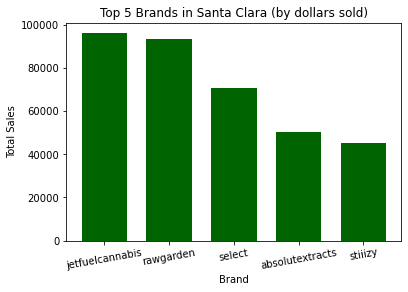

In [13]:
# creating a barplot for the top 5 brands in Santa Clara
plt.bar(sanat_clara_top_brand.index[:5], sanat_clara_top_brand['total_sales'][:5], color='darkgreen', width=0.7)
plt.xticks(rotation = 10)
plt.xlabel('Brand')
plt.ylabel('Total Sales')
plt.title('Top 5 Brands in Santa Clara (by dollars sold)')
plt.show()

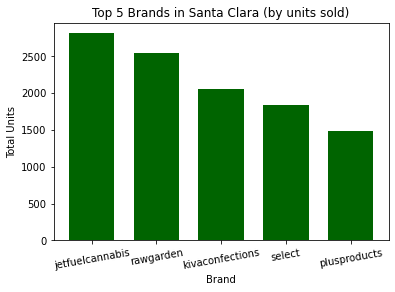

In [14]:
# creating a barplot for the top 5 brands in Santa Clara
sanat_clara_top_brand = sanat_clara_top_brand.sort_values('total_units', ascending=False)
plt.bar(sanat_clara_top_brand.index[:5], sanat_clara_top_brand['total_units'][:5], color='darkgreen', width=0.7)
plt.xticks(rotation = 10)
plt.xlabel('Brand')
plt.ylabel('Total Units')
plt.title('Top 5 Brands in Santa Clara (by units sold)')
plt.show()

In [15]:
# What is the top product in Santa Clara?
# aggregating to determine the top product
santa_clara_top_product = santa_clara \
    .groupby('granular_product') \
    .agg(
        total_sales = pd.NamedAgg('os__sales', 'sum'),
        total_units = pd.NamedAgg('os__n_units', 'sum'),
    ) \
    .sort_values('total_sales', ascending=False)

santa_clara_top_product.head(5)

,total_sales,total_units
granular_product,,
"Jack Herer: 0, by jetfuelcannabis",23328.5,534
"Chocolate Haze: 0, by jetfuelcannabis",13044.6,323
"Jack Rabbit: 0, by jetfuelcannabis",9156.4,228
"Master Kush: 0, by jetfuelcannabis",8687.9,242
"Tahoe OG: 0, by jetfuelcannabis",6858.0,186


### Bottom market

In [16]:
county_total_sales.tail(5)

,total_sales
s__estimated_county,
Stanislaus,4323.55
Inyo,3789.40
Tuolumne,3219.06
Humboldt,300.50
Lake,123.88


In [17]:
# Exploring the county with the lowest sales: Lake
# subsetting the data frame to only include transactions from Lake
lake = transactions_df[transactions_df['s__estimated_county'] == 'Lake']

In [18]:
# Per day statistics
lake_per_day_stats = lake \
    .groupby('os__checkout_date') \
    .agg(
        total_sales = pd.NamedAgg('os__sales', 'sum'),
        avg_transaction_value = pd.NamedAgg('os__sales', 'mean'),
        total_units = pd.NamedAgg('os__n_units', 'sum'),
        avg_units_per_transaction = pd.NamedAgg('os__n_units', 'mean')
    ) \
    .sort_values('os__checkout_date', ascending=False)

lake_per_day_stats.head()

,total_sales,avg_transaction_value,total_units,avg_units_per_transaction
os__checkout_date,,,,
2021-05-30,55.00,55.00,1,1
2021-05-13,68.88,22.96,3,1


In [19]:
# What are the top 5 brandsin Lake?
# aggregating by brands
lake_top_brand = lake \
    .groupby('p__serial_brand') \
    .agg(
        total_sales = pd.NamedAgg('os__sales', 'sum'),
        total_units = pd.NamedAgg('os__n_units', 'sum'),
    ) \
    .sort_values('total_sales', ascending=False)

lake_top_brand.head(5)

,total_sales,total_units
p__serial_brand,,
darkheartnursery,68.88,3
papasselect,55.00,1


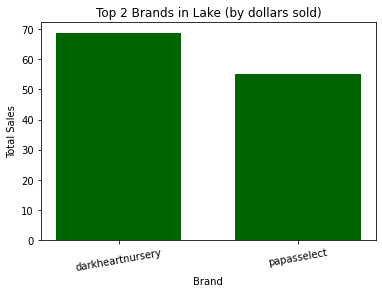

In [20]:
# creating a barplot for the top 2 brands in Lake
plt.bar(lake_top_brand.index[:5], lake_top_brand['total_sales'][:5], color='darkgreen', width=0.7)
plt.xticks(rotation = 10)
plt.xlabel('Brand')
plt.ylabel('Total Sales')
plt.title('Top 2 Brands in Lake (by dollars sold)')
plt.show()

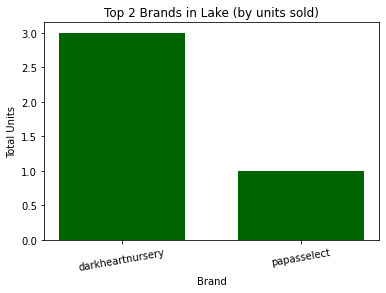

In [21]:
# creating a barplot for the top 2 brands in Lake
lake_top_brand = lake_top_brand.sort_values('total_units', ascending=False)
plt.bar(lake_top_brand.index[:5], lake_top_brand['total_units'][:5], color='darkgreen', width=0.7)
plt.xticks(rotation = 10)
plt.xlabel('Brand')
plt.ylabel('Total Units')
plt.title('Top 2 Brands in Lake (by units sold)')
plt.show()

In [22]:
# What is the top product in Lake?
# aggregating to determine the top product
lake_top_product = lake \
    .groupby('granular_product') \
    .agg(
        total_sales = pd.NamedAgg('os__sales', 'sum'),
        total_units = pd.NamedAgg('os__n_units', 'sum'),
    ) \
    .sort_values('total_sales', ascending=False)

lake_top_product.head(5)

,total_sales,total_units
granular_product,,
"Papaya Berry Sorbet: 2, by papasselect",55.00,1
"Ice Cream Cake: 4, by darkheartnursery",22.96,1
"Ken's Granddaddy Purple: 4, by darkheartnursery",22.96,1
"Skywalker OG: 4, by darkheartnursery",22.96,1


### Select markets vs overall data set

In [23]:
# Exploring the remaining counties: excluding Santa Clara and Lake
# subsetting the data frame to not include transactions from Santa Clara or Lake
remaining_counties = transactions_df[transactions_df['s__estimated_county'] != 'Lake']
remaining_counties = transactions_df[transactions_df['s__estimated_county'] != 'Santa Clara']

In [24]:
# Per day statistics
remaining_counties_per_day_stats = remaining_counties \
    .groupby('os__checkout_date') \
    .agg(
        total_sales = pd.NamedAgg('os__sales', 'sum'),
        avg_transaction_value = pd.NamedAgg('os__sales', 'mean'),
        total_units = pd.NamedAgg('os__n_units', 'sum'),
        avg_units_per_transaction = pd.NamedAgg('os__n_units', 'mean')
    ) \
    .sort_values('os__checkout_date', ascending=False)

remaining_counties_per_day_stats.head()

,total_sales,avg_transaction_value,total_units,avg_units_per_transaction
os__checkout_date,,,,
2021-05-31,48764.45,36.775603,1603,1.208899
2021-05-30,54862.31,38.365252,1882,1.316084
2021-05-29,56942.33,37.023622,1927,1.252926
2021-05-28,67969.14,38.249375,2239,1.259989
2021-05-27,52973.01,37.410318,1854,1.309322


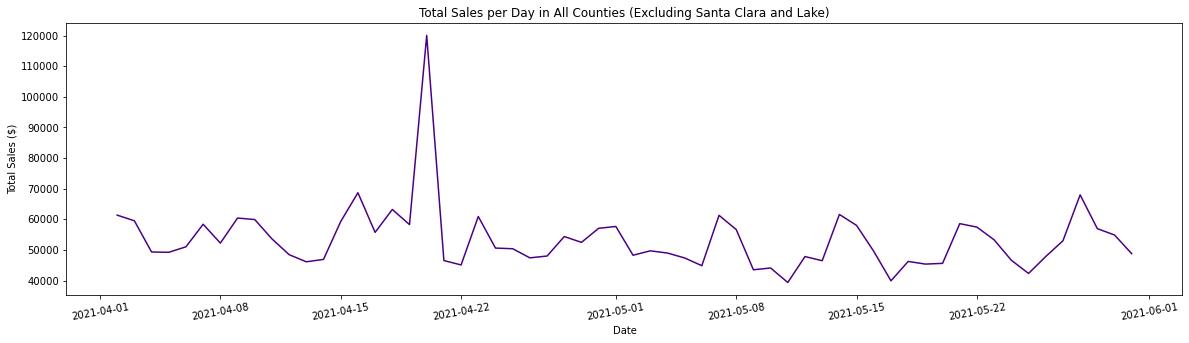

In [25]:
fig = plt.figure(figsize = (20, 5))
plt.plot(remaining_counties_per_day_stats.index, remaining_counties_per_day_stats['total_sales'], color='indigo')
plt.xticks(rotation = 10)
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.title('Total Sales per Day in All Counties (Excluding Santa Clara and Lake)')
plt.show()

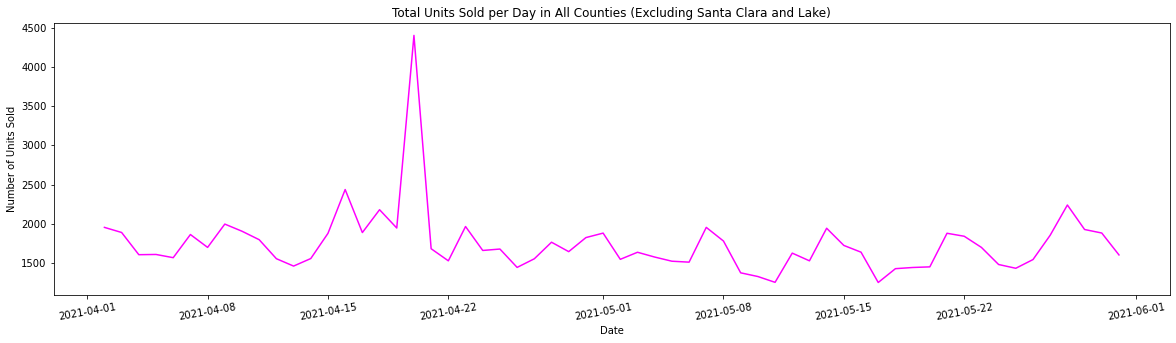

In [26]:
fig = plt.figure(figsize = (20, 5))
plt.plot(remaining_counties_per_day_stats.index, remaining_counties_per_day_stats['total_units'], color='magenta')
plt.xticks(rotation = 10)
plt.xlabel('Date')
plt.ylabel('Number of Units Sold')
plt.title('Total Units Sold per Day in All Counties (Excluding Santa Clara and Lake)')
plt.show()

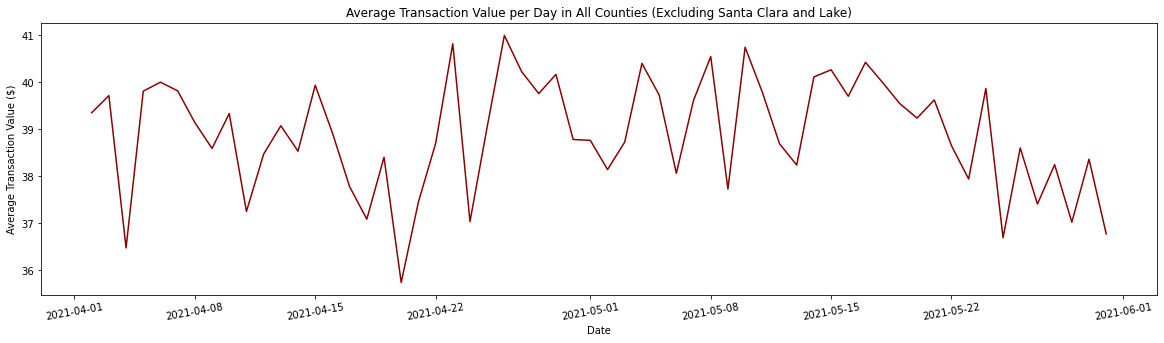

In [27]:
fig = plt.figure(figsize = (20, 5))
plt.plot(remaining_counties_per_day_stats.index, remaining_counties_per_day_stats['avg_transaction_value'], color='darkred')
plt.xticks(rotation = 10)
plt.xlabel('Date')
plt.ylabel('Average Transaction Value ($)')
plt.title('Average Transaction Value per Day in All Counties (Excluding Santa Clara and Lake)')
plt.show()

In [28]:
# What are the top 5 brandsin the remaining counties?
# aggregating by brands
remaining_counties_top_brand = remaining_counties \
    .groupby('p__serial_brand') \
    .agg(
        total_sales = pd.NamedAgg('os__sales', 'sum'),
        total_units = pd.NamedAgg('os__n_units', 'sum'),
    ) \
    .sort_values('total_sales', ascending=False)

remaining_counties_top_brand.head(5)

,total_sales,total_units
p__serial_brand,,
rawgarden,120964.78,2979
stiiizy,114047.52,3457
kivaconfections,77250.85,3696
glasshousefarms,67943.93,2100
heavyhitters,61382.22,1434


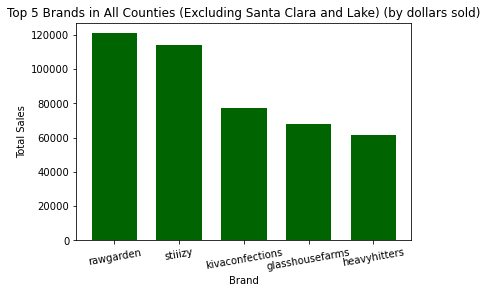

In [29]:
# creating a barplot for the top 5 brands in the remaining counties
plt.bar(remaining_counties_top_brand.index[:5], remaining_counties_top_brand['total_sales'][:5], color='darkgreen', width=0.7)
plt.xticks(rotation = 10)
plt.xlabel('Brand')
plt.ylabel('Total Sales')
plt.title('Top 5 Brands in All Counties (Excluding Santa Clara and Lake) (by dollars sold)')
plt.show()

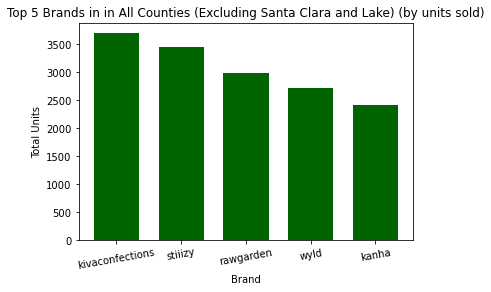

In [30]:
# creating a barplot for the top 5 brands in the remaining counties
remaining_counties_top_brand = remaining_counties_top_brand.sort_values('total_units', ascending=False)
plt.bar(remaining_counties_top_brand.index[:5], remaining_counties_top_brand['total_units'][:5], color='darkgreen', width=0.7)
plt.xticks(rotation = 10)
plt.xlabel('Brand')
plt.ylabel('Total Units')
plt.title('Top 5 Brands in in All Counties (Excluding Santa Clara and Lake) (by units sold)')
plt.show()

In [31]:
# What is the top product in the remaning counties?
# aggregating to determine the top product
remaining_counties_top_product = remaining_counties \
    .groupby('granular_product') \
    .agg(
        total_sales = pd.NamedAgg('os__sales', 'sum'),
        total_units = pd.NamedAgg('os__n_units', 'sum'),
    ) \
    .sort_values('total_sales', ascending=False)

remaining_counties_top_product.head(5)

,total_sales,total_units
granular_product,,
"5:1 Midnight Blueberry (20mg CBN/100mg THC): 1, by kivaconfections",12885.73,624
"Elderberry [10pk] (100mg THC/50mg CBN): 1, by wyld",9324.80,418
"Sour Watermelon [20pk] (100mg): 1, by plusproducts",8895.49,476
"Super Sour Diesel: 0, by scva",7796.15,147
"Wedding Cake: 0, by pacificstone",7686.54,173


## Ascertaining an investor’s outlook on the cannabis industry -- Weedmaps sentiment analysis

In [32]:
# collecting recent articles 
def get_articles(company_ticker, number_of_articles=50):
    """
    """
    print('Retrieving the', number_of_articles, 'most recent articles for ticker symbol', company_ticker, 'on MarketWatch.')
    
    # creating the link to request
    query_link = 'https://www.marketwatch.com/search?q=' + str(company_ticker) + '&m=Keyword&rpp=' + str(number_of_articles) + '&mp=0&bd=false&rs=false'
    
    # requesting data
    all_articles = requests.get(query_link)
    
    # parsing the data as html
    all_articles_soup =  BeautifulSoup(all_articles.content, 'html.parser')
    
    # extracting the urls
    url_vector = []
    
    # -- the location of the urls
    searchresults = all_articles_soup.find_all('div', 'searchresult')
    for item in searchresults:
        current_url = str(item.find('a')['href'])
        
        # -- adding `http` since not all urls are formatted correctly 
        if not (current_url.startswith('http')):
            current_url = 'http://www.marketwatch.com' + current_url
        
        url_vector.append(current_url)
        
    # extracting the dates and datetimes
    datetime_vector = []
    date_vector = []
    
    # -- the location of the dates
    times = all_articles_soup.find_all('div', 'deemphasized')
    for item in times:
        current_time = str(item.find('span').text)
        
        # -- cleaning how MarketWatch reports times
        if 'Today' in current_time:

            string_to_remove = current_time[0:current_time.find('Today') + 5]
            print("Removing '" + string_to_remove + "' because it is an invalid time structure...")

            current_time = current_time.replace(string_to_remove, '')

        if 'p.m.' in current_time:
            current_time = current_time.replace('p.m.', 'PM')
        else:
            current_time = current_time.replace('a.m.', 'AM')

        if 'March' in current_time:
            current_time = current_time.replace('March', 'Mar.')
            
        if 'April' in current_time:
            current_time = current_time.replace('April', 'Apr.')
            
        if 'May' in current_time:
            current_time = current_time.replace('May', 'May.')
            
        if 'July' in current_time:
            current_time = current_time.replace('July', 'Jul.')

        if 'June' in current_time:
            current_time = current_time.replace('June', 'Jun.')
        
        if 'Sept' in current_time:
            current_time = current_time.replace('Sept.', 'Sep.')

        current_datetime = datetime.strptime(current_time, '%I:%M %p %b. %d, %Y')
        current_date = current_datetime.date()    


        datetime_vector.append(current_datetime)
        date_vector.append(current_date)
    
    # extracting the titles and the bodies from each article
    title_vector = []
    body_vector = []
    collected_webpages = 0
    for webpage in url_vector:
        article = requests.get(webpage)
        article_soup = BeautifulSoup(article.content, 'html.parser')

        current_article_title = article_soup.find('title').text
        current_article_body = article_soup.find('p').text

        title_vector.append(current_article_title)
        body_vector.append(current_article_body)

        collected_webpages += 1

        print('Collected ' + str(collected_webpages) + '/' + str(len(url_vector)) + ' articles...')
    
    # creating a dataframe with all the collected information
    articles_df = pd.DataFrame(
        list(zip(url_vector, datetime_vector, date_vector, title_vector, body_vector)),
        columns=['url', 'date_time', 'date', 'title', 'body']
    )
    
    print('Done. Collected all articles.')
    
    return articles_df

In [33]:
weedmaps_articles = get_articles('maps', number_of_articles=100)

Retrieving the 100 most recent articles for ticker symbol maps on MarketWatch.
Collected 1/100 articles...
Collected 2/100 articles...
Collected 3/100 articles...
Collected 4/100 articles...
Collected 5/100 articles...
Collected 6/100 articles...
Collected 7/100 articles...
Collected 8/100 articles...
Collected 9/100 articles...
Collected 10/100 articles...
Collected 11/100 articles...
Collected 12/100 articles...
Collected 13/100 articles...
Collected 14/100 articles...
Collected 15/100 articles...
Collected 16/100 articles...
Collected 17/100 articles...
Collected 18/100 articles...
Collected 19/100 articles...
Collected 20/100 articles...
Collected 21/100 articles...
Collected 22/100 articles...
Collected 23/100 articles...
Collected 24/100 articles...
Collected 25/100 articles...
Collected 26/100 articles...
Collected 27/100 articles...
Collected 28/100 articles...
Collected 29/100 articles...
Collected 30/100 articles...
Collected 31/100 articles...
Collected 32/100 articles...
Co

In [34]:
# cleaning the collected articles
def clean_text_data(text_vector):
    """
    """
    cleaned_text_vector = []
    
    for strings in text_vector:
        
        print('Converting all text to lowercase...')
        current_text = strings.lower()

        print('Removing punctuation...')
        current_text = re.sub(r'[^\w\s]', '', current_text)
        
        print('Removing stopwords...')
        market_watch_stopwords = ["marketwatch", "mw", "zachs", "zacks", "barron"]
        all_stopwords = market_watch_stopwords + stopwords.words('english')
        querysplit = current_text.split()
        resultwords = [word for word in querysplit if word not in all_stopwords]
        current_text = ' '.join(resultwords)
        
        # saving the cleaned text as a new vector
        cleaned_text_vector.append(current_text)
    
    return cleaned_text_vector

In [35]:
cleaned_weedmaps_titles = clean_text_data(weedmaps_articles.title[0:len(weedmaps_articles)])
cleaned_weedmaps_bodies = clean_text_data(weedmaps_articles.body[0:len(weedmaps_articles)])
weedmaps_articles['title'] = cleaned_weedmaps_titles
weedmaps_articles['body'] = cleaned_weedmaps_bodies

Converting all text to lowercase...
Removing punctuation...
Removing stopwords...
Converting all text to lowercase...
Removing punctuation...
Removing stopwords...
Converting all text to lowercase...
Removing punctuation...
Removing stopwords...
Converting all text to lowercase...
Removing punctuation...
Removing stopwords...
Converting all text to lowercase...
Removing punctuation...
Removing stopwords...
Converting all text to lowercase...
Removing punctuation...
Removing stopwords...
Converting all text to lowercase...
Removing punctuation...
Removing stopwords...
Converting all text to lowercase...
Removing punctuation...
Removing stopwords...
Converting all text to lowercase...
Removing punctuation...
Removing stopwords...
Converting all text to lowercase...
Removing punctuation...
Removing stopwords...
Converting all text to lowercase...
Removing punctuation...
Removing stopwords...
Converting all text to lowercase...
Removing punctuation...
Removing stopwords...
Converting all t

In [36]:
# calculating the sentiment per article
def calculate_sentiment_score(text_vector):
    """
    """
    sentiment_socres = []
    
    print('Calculating the sentiment socre...')
    for text in text_vector:
        current_sentiment = TextBlob(text).sentiment
        
        sentiment_socres.append(current_sentiment[0])
    
    print('Done. Sentiment score calculated.')
    return sentiment_socres

In [37]:
weedmaps_articles['title_polarity'] = calculate_sentiment_score(weedmaps_articles.title[0:len(weedmaps_articles)])
weedmaps_articles['body_polarity'] = calculate_sentiment_score(weedmaps_articles.body[0:len(weedmaps_articles)])

Calculating the sentiment socre...
Done. Sentiment score calculated.
Calculating the sentiment socre...
Done. Sentiment score calculated.


In [38]:
# summing the sentiment scores from the titles and bodies of each article
weedmaps_articles['total_article_polarity'] = weedmaps_articles['title_polarity'] + weedmaps_articles['body_polarity']
weedmaps_articles['avg_article_polarity'] = weedmaps_articles['total_article_polarity'] / 2.0

In [39]:
weedmaps_articles

,url,date_time,date,title,body,title_polarity,body_polarity,total_article_polarity,avg_article_polarity
0,http://www.marketwatch.com/story/texas-republi...,2021-09-08 17:42:00,2021-09-08,texas republicans take hard right turn democra...,austin texas ap republicans americas largest c...,-0.002976,0.000000,-0.002976,-0.001488
1,http://www.marketwatch.com/story/hurricane-ida...,2021-09-04 09:53:00,2021-09-04,americans could making 44 billion mistake come...,remnants hurricane ida passed midatlantic regi...,0.000000,0.000000,0.000000,0.000000
2,http://www.marketwatch.com/story/8-tips-for-wo...,2021-09-02 05:02:00,2021-09-02,8 tips women traveling alone,article reprinted permission nerdwallet,0.000000,0.000000,0.000000,0.000000
3,http://www.marketwatch.com/story/illinois-demo...,2021-08-31 23:48:00,2021-08-31,illinois democrats approve new legislative map...,chicago illinois democrats poised set new legi...,0.136364,-0.190909,-0.054545,-0.027273
4,http://www.marketwatch.com/story/texas-legisla...,2021-08-31 17:44:00,2021-08-31,texas legislature sends sweeping republican bi...,austin texas texas legislature sent sweeping r...,0.000000,-0.100000,-0.100000,-0.050000
...,...,...,...,...,...,...,...,...,...
95,http://www.marketwatch.com/articles/big-money-...,2020-12-12 08:30:00,2020-12-12,big money managers set goal net zero greenhous...,major asset managers including fidelity intern...,0.000000,0.020833,0.020833,0.010417
96,http://www.marketwatch.com/story/ericsson-and-...,2020-12-10 12:34:00,2020-12-10,new drone technology uses data mobile networks...,ericsson eric 101 vodafone vod 036 said succes...,-0.131818,0.383333,0.251515,0.125758
97,http://www.marketwatch.com/story/still-refusin...,2020-12-08 16:05:00,2020-12-08,still refusing wear mask bill nye would like word,bill nye struck tiktok gold weekend racking 14...,0.000000,0.500000,0.500000,0.250000
98,http://www.marketwatch.com/story/could-the-fed...,2020-11-17 05:17:00,2020-11-17,could fed act early yes says strategist maps c...,,0.025000,0.000000,0.025000,0.012500


In [40]:
# determining daily polarity of all articles
weedmaps_daily_polarity = weedmaps_articles \
    .groupby('date') \
    .agg(
        total_polarity = pd.NamedAgg('total_article_polarity', 'sum'),
        avg_polarity = pd.NamedAgg('total_article_polarity', 'mean'),
    ) \
    .sort_values('date', ascending=True)

In [41]:
weedmaps_daily_polarity

,total_polarity,avg_polarity
date,,
2020-11-16,0.200000,0.200000
2020-11-17,0.025000,0.025000
2020-12-08,0.500000,0.500000
2020-12-10,0.251515,0.251515
2020-12-12,0.020833,0.020833
...,...,...
2021-08-28,0.000000,0.000000
2021-08-31,-0.154545,-0.077273
2021-09-02,0.000000,0.000000


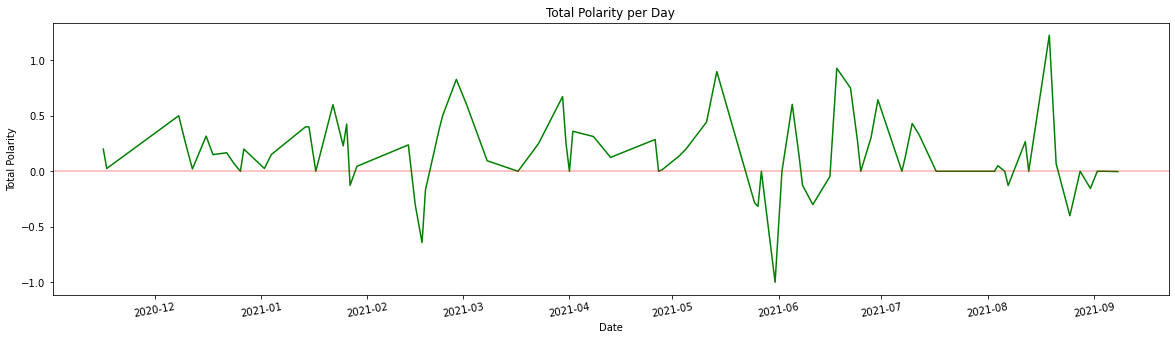

In [42]:
fig = plt.figure(figsize = (20, 5))
plt.plot(weedmaps_daily_polarity.index, weedmaps_daily_polarity['total_polarity'], color='green')
plt.axhline(y=0.0, color='r', linestyle='-', alpha=0.3)
plt.xticks(rotation = 10)
plt.xlabel('Date')
plt.ylabel('Total Polarity')
plt.title('Total Polarity per Day')
plt.show()

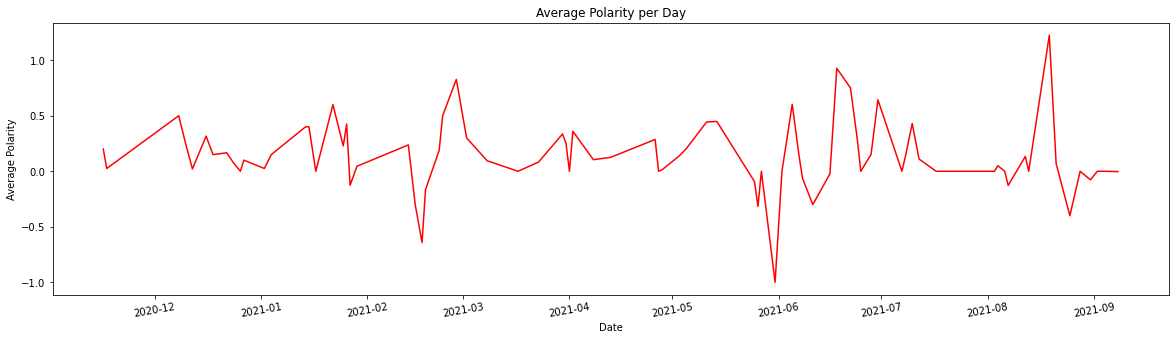

In [43]:
fig = plt.figure(figsize = (20, 5))
plt.plot(weedmaps_daily_polarity.index, weedmaps_daily_polarity['avg_polarity'], color='red')
plt.xticks(rotation = 10)
plt.xlabel('Date')
plt.ylabel('Average Polarity')
plt.title('Average Polarity per Day')
plt.show()

In [44]:
# determing the avg of the daily polarities
avg_daily_weedmaps_polarity = round(weedmaps_daily_polarity['total_polarity'].mean(), 3)
print('On average, the polarity of the articles re: Weedmaps is ' + str(avg_daily_weedmaps_polarity) + '.')

On average, the polarity of the articles re: Weedmaps is 0.16.


In [45]:
# determing the avg monthly polarity
avg_monthly_weedmaps_polarity = weedmaps_daily_polarity

months = []
years = []

for i in range(0, len(weedmaps_daily_polarity)):
    current_month = weedmaps_daily_polarity.index[i].month
    current_year = weedmaps_daily_polarity.index[i].year
    
    months.append(current_month)
    years.append(current_year)
    
avg_monthly_weedmaps_polarity['month'] = months
avg_monthly_weedmaps_polarity['year'] = years

avg_monthly_weedmaps_polarity = avg_monthly_weedmaps_polarity \
    .groupby(['month', 'year']) \
    .agg(
        avg_polarity = pd.NamedAgg('total_polarity', 'mean')
    ) \
    .sort_values(['year', 'month'], ascending=[True, True])

year_month_dates = [] 
for i in range(0, len(avg_monthly_weedmaps_polarity)):
    
    current_year_month_date = (avg_monthly_weedmaps_polarity.index[i][0]).astype('str') + '-' + (avg_monthly_weedmaps_polarity.index[i][1]).astype('str')
    current_year_month_date = datetime.strptime(current_year_month_date, '%m-%Y').date()
    year_month_dates.append(current_year_month_date)
    
avg_monthly_weedmaps_polarity['date'] = year_month_dates

In [46]:
avg_monthly_weedmaps_polarity

,,avg_polarity,date
month,year,,
11,2020,0.112500,2020-11-01
12,2020,0.186742,2020-12-01
1,2021,0.214698,2021-01-01
2,2021,0.119314,2021-02-01
3,2021,0.311212,2021-03-01
4,2021,0.156699,2021-04-01
5,2021,0.009950,2021-05-01
6,2021,0.264619,2021-06-01
7,2021,0.148561,2021-07-01


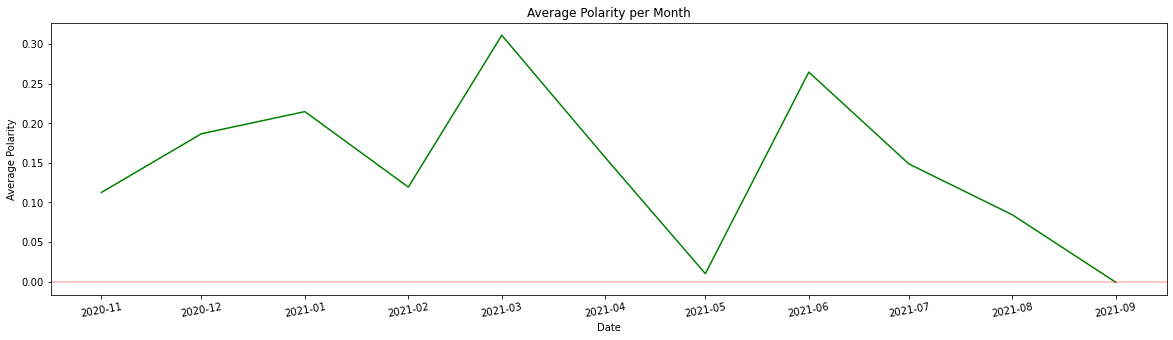

In [47]:
fig = plt.figure(figsize = (20, 5))
plt.plot(avg_monthly_weedmaps_polarity.date, avg_monthly_weedmaps_polarity['avg_polarity'], color='green')
plt.axhline(y=0.0, color='r', linestyle='-', alpha=0.3)
plt.xticks(rotation = 10)
plt.xlabel('Date')
plt.ylabel('Average Polarity')
plt.title('Average Polarity per Month')
plt.show()

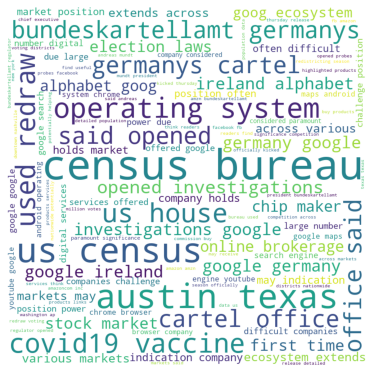

In [50]:
# generating a worldcloud to determine frequent words within the articles 
article_words = ''
for string in weedmaps_articles.body:
    string = str(string)
    tokens = string.split()
    
    for i in range(len(tokens)):
        article_words += " ".join(tokens)+" "
    
cloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(article_words)

plt.figure(figsize=(20, 5), facecolor=None)
plt.imshow(cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()